In [29]:
import numpy as np
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load dataset
dataset = BNCI2014_001()
paradigm = MotorImagery(n_classes=4)

# Get data for subject 1 
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[2])


Choosing from all possible events
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/

In [30]:
# Create pipeline with covariance estimation and MDM classifier
mdrm = make_pipeline(
    Covariances(estimator='scm'),  # Sample Covariance Matrix estimation
    MDM()  # Minimum Distance to Mean classifier
)

# Compute cross-validation score
mdrm_scores = cross_val_score(mdrm, X, labels, cv=30)


In [31]:
# Create pipeline with covariance estimation, tangent space mapping and LDA
tslda = make_pipeline(
    Covariances(estimator='scm'),
    TangentSpace(metric='riemann'),
    LinearDiscriminantAnalysis(solver='svd')
)

# Compute cross-validation score
tslda_scores = cross_val_score(tslda, X, labels, cv=30)


/tmp/ipykernel_65115/2318338758.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],


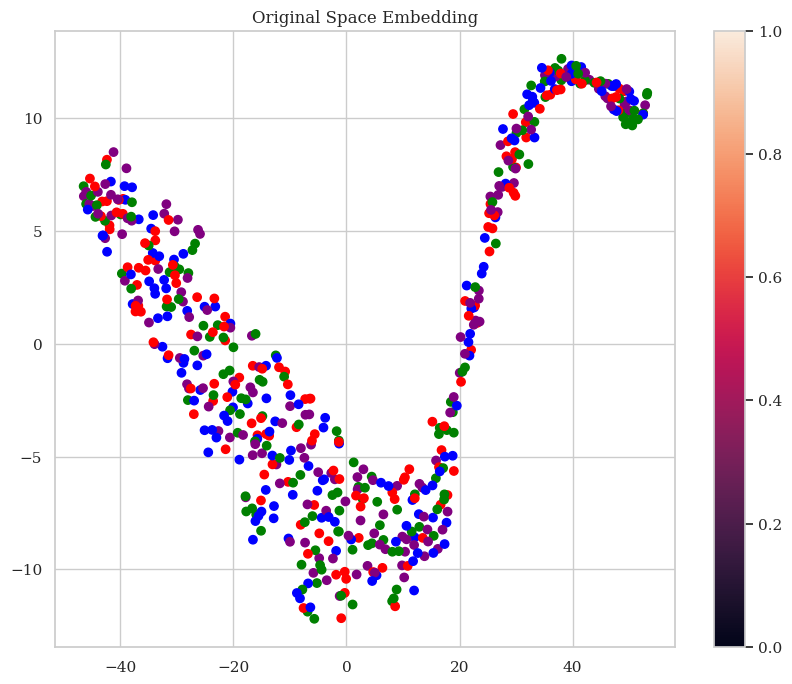

/tmp/ipykernel_65115/2318338758.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],


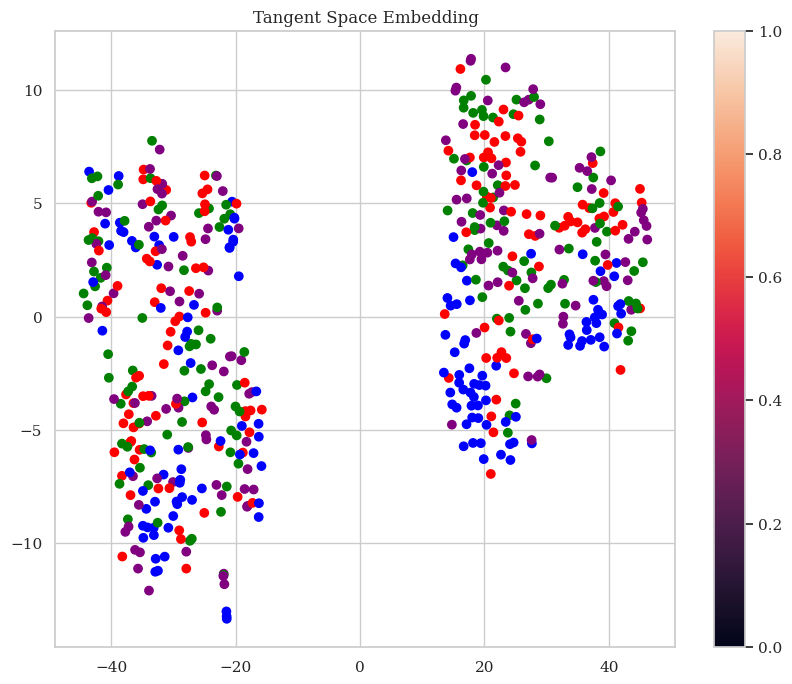

MDRM Average Accuracy: 0.570 ± 0.142
TSLDA Average Accuracy: 0.526 ± 0.099


In [32]:
def visualize_embeddings(X, labels, title, method='original'):
    # Estimate covariance matrices
    covs = Covariances(estimator='scm').fit_transform(X)
    
    if method == 'tangent':
        # Transform to tangent space
        ts = TangentSpace(metric='riemann')
        vectors = ts.fit_transform(covs)
    else:
        # For original space, vectorize covariance matrices
        vectors = covs.reshape(covs.shape[0], -1)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(vectors)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                         c=labels, cmap='tab10')
    plt.title(title)
    plt.colorbar(scatter)
    plt.show()

# Visualize embeddings
color_map = {
    'tongue': 'red',
    'feet': 'blue',
    'left_hand': 'green',
    'right_hand': 'purple'
}

# Map your labels to colors
colors = [color_map[label] for label in labels]

visualize_embeddings(X, colors, "Original Space Embedding", method='original')
visualize_embeddings(X, colors, "Tangent Space Embedding", method='tangent')

# Print results
print(f"MDRM Average Accuracy: {np.mean(mdrm_scores):.3f} ± {np.std(mdrm_scores):.3f}")
print(f"TSLDA Average Accuracy: {np.mean(tslda_scores):.3f} ± {np.std(tslda_scores):.3f}")
